In [9]:
import cv2 as cv
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import *
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)
from tqdm import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

In [6]:
classes={0:'Safe Driving'
         ,1:'texting - right'
         ,2:'talking on the phone - right'
         ,3:'texting - left'
         ,4:'talking on the phone - left'
         ,5:'operating the radio'
         ,6:'drinking'
         ,7:'reaching behind'
         ,8:'hair and makeup'
         ,9:'talking to passenger'}
data1 = pd.read_csv('../files/driver_imgs_list.csv')
for j in np.unique(data1["classname"]):
    print ("clase :",j,"Numero de ejemplares:",np.count_nonzero(data1["classname"][data1.classname==j]))

('clase :', 'c0', 'Numero de ejemplares:', 2489)
('clase :', 'c1', 'Numero de ejemplares:', 2267)
('clase :', 'c2', 'Numero de ejemplares:', 2317)
('clase :', 'c3', 'Numero de ejemplares:', 2346)
('clase :', 'c4', 'Numero de ejemplares:', 2326)
('clase :', 'c5', 'Numero de ejemplares:', 2312)
('clase :', 'c6', 'Numero de ejemplares:', 2325)
('clase :', 'c7', 'Numero de ejemplares:', 2002)
('clase :', 'c8', 'Numero de ejemplares:', 1911)
('clase :', 'c9', 'Numero de ejemplares:', 2129)


### Data For Dictionary:

In [8]:
path_images='../../datasets/driver-detections/train/'
descriptor_extractor = ORB(n_keypoints=200)
array_ORB=[]
size=100 #<1911
for i in tqdm(np.unique(data1["classname"])):
    for j in np.random.choice(data1["img"][data1.classname==i],size):
    #for j in data1["img"][data1.classname==i]:
        temp_image=cv.cvtColor(cv.imread(path_images+i+"/"+j), cv.COLOR_BGR2GRAY)
        descriptor_extractor.detect_and_extract(temp_image)    
        if(len(array_ORB)==0):
            array_ORB=descriptor_extractor.descriptors 
        else:
            array_ORB=np.vstack((array_ORB,descriptor_extractor.descriptors))



100%|██████████| 10/10 [08:17<00:00, 49.78s/it]


### Dictionary Creation:

In [10]:
from sklearn.cluster import KMeans
v_words=70
estimator=KMeans(n_clusters=v_words).fit(array_ORB)
dictionary=estimator.cluster_centers_ 
print dictionary.shape

(70, 256)


### Histogram Dataset:

In [11]:
def build_histogram(descriptor_list, cluster_alg):
    histogram = np.zeros(len(cluster_alg.cluster_centers_))
    cluster_result =  cluster_alg.predict(descriptor_list)
    for i in cluster_result:
        histogram[i] += 1.0
    return histogram

In [12]:
X=[]
y=[]
size=1000 #<1911
descriptor_extractor = ORB(n_keypoints=200)
for i in tqdm(np.unique(data1["classname"])):
    #for j in data1["img"][data1.classname==i]:
    for j in np.random.choice(data1["img"][data1.classname==i],size):  
        temp_image=cv.cvtColor(cv.imread(path_images+i+"/"+j), cv.COLOR_BGR2GRAY)
        descriptor_extractor.detect_and_extract(temp_image)
        temp_desc = descriptor_extractor.descriptors
        X.append(build_histogram(temp_desc, estimator))
        y.append(int(i[-1]))   
         
        
X=np.array(X)
y=np.array(y)

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,shuffle=1)

100%|██████████| 10/10 [1:13:28<00:00, 440.84s/it]


Now, we can use machine learning algorithms to train ans test the **visual word occurrence descriptors**

In [13]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

GN_est = GaussianNB()
RF_est = RandomForestClassifier(n_estimators=40)
SV_est = SVC(kernel='rbf')
KN_est = KNeighborsClassifier(n_neighbors=10)

With a K-nearest classifier

0.7855


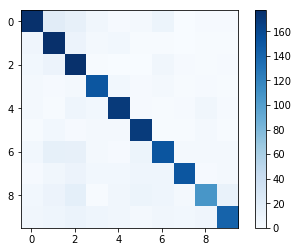

In [14]:
KN_est.fit(X_train, y_train)
KN_pr = KN_est.predict(X_test)
print KN_est.score(X_test, y_test)
cm_test = confusion_matrix(y_test, KN_pr)

plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

With Gaussian

0.277


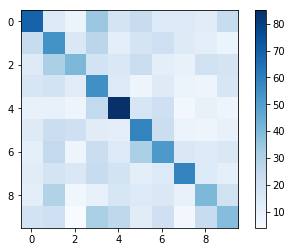

In [15]:
GN_est.fit(X_train, y_train)
GN_pr = GN_est.predict(X_test)
print GN_est.score(X_test,y_test)
cm_test = confusion_matrix(y_test, GN_pr)

plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

With Random Forest

0.703


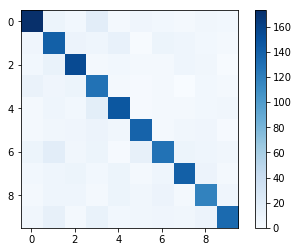

In [16]:
RF_est.fit(X_train,y_train)
RF_pr = RF_est.predict(X_test)
print RF_est.score(X_test,y_test)
cm_test = confusion_matrix(y_test, RF_pr)

plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();

With SVC

0.7725


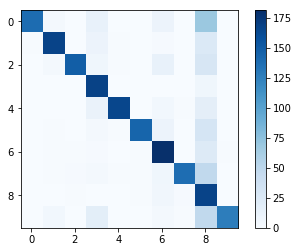

In [17]:
SV_est.fit(X_train,y_train)
SV_pr = SV_est.predict(X_test)
print SV_est.score(X_test,y_test)
cm_test = confusion_matrix(y_test, SV_pr)

plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.colorbar();